In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# set default font sizes for plots

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)

In [3]:
# for virtual patient cohort simulations
N = 1000 # cohort size
n_vpc = 100 # number of cohorts

mvec = [10,20,30,40,50,60,70,80,90] #drug doses
tmax=300 # final time point for simulations
tvec = np.linspace(0,tmax,num = 5000) # time span for solutions
len_tspan = int((tmax)/3)+1
tspan = np.linspace(0,tmax,len_tspan) # time span for KM curves

In [34]:
# define dictionary for varying PSR and ESR (four cases: A,B,C,D)
param_dict = {'A': [50, 0.2], 'B': [10, 0.2], 'C': [50, 0.02], 'D': [10, 0.02]}

# set string for case (A,B,C,D), get corresponding values of PSR & ESR (for saving figures/data)
mycase = 'C'
PSR, ESR = param_dict[mycase]

<b> Only need to run the following six cells once for each case. After that, only need to load the appropriate .csv files. </b>

In [27]:
# universal parameters: dose-response parameters
# logistic "growth" rate (drug "sensitivity")
rS = 0.2
rR = 0.2
rSR = 0.2
# half-maximum point (drug "potency")
PS = 20
PR = 20
# amplitude (drug "efficacy")
ES = 0.3
ER = 0.04

In [5]:
# construct n_vpc virtual patient cohorts of N patients each (assuming uniform prior)

# draw random initial conditions 
xi = np.random.uniform(0,1,(N,n_vpc)) # fraction of resistant cells at detection
N0 = 1e9 # tumor size at detection
X0mat = np.zeros((2,N,n_vpc))
X0mat[0,:,:] = (1-xi)*N0
X0mat[1,:,:] = xi*N0

# draw random values for remaining parameters (basal birth, death, and switching rates)
# assume uniform distribution (prior)
# distribution paramters selected so that mean value is equal to fixed value from singlet simulations
#     see 'parameters.py' file
# cell division rates
bS = np.random.uniform(0.1,0.3,(N,n_vpc)) 
bR = np.random.uniform(0.05,0.15,(N,n_vpc)) 
# phenotype switching rate R->S
kRS = np.random.uniform(0.0,0.02,(N,n_vpc))
# other basal rates
delS = np.random.uniform(0.01,0.03,(N,n_vpc)) # basal sens death rate
delR = np.random.uniform(0.01,0.03,(N,n_vpc)) # basal res death rate
kappa = np.random.uniform(0.0,0.02,(N,n_vpc)) # basal transition S->R

In [83]:
# define dose response curves for cohort (function of drug dose)
dS = lambda m: delS + ES/(1+np.exp(-rS*(m-PS))) # sens death rate
dR = lambda m: delR + ER/(1+np.exp(-rR*(m-PR))) # res death rate
kSR = lambda m: kappa + ESR/(1+np.exp(-rSR*(m-PSR))) # transition S->R

# define net growth rates
gS = lambda m: bS - dS(m)
gR = lambda m: bR - dR(m)

# miscellaneous constants & eigenvalues/vectors
alpha = lambda m: gR(m)-gS(m)+kSR(m)-kRS
mybeta = lambda m: np.sqrt(alpha(m)**2 + 4*kSR(m)*kRS)
lam1 = lambda m: 0.5*(gS(m)+gR(m)-kSR(m)-kRS+mybeta(m))
lam2 = lambda m: 0.5*(gS(m)+gR(m)-kSR(m)-kRS-mybeta(m))
vec1 = lambda m: (-alpha(m)+mybeta(m))/(2*kSR(m))
vec2 = lambda m: (-alpha(m)-mybeta(m))/(2*kSR(m))

In [84]:
def find_TTP(idx1,idx2,init,v1,v2,l1,l2,t):
    '''documentation'''
    x0 = init[:,idx1,idx2]
    # compute eigenvectors (v_1, v_2) of A and coefficients (c_1, c_2) for true solution
    V = np.array([[v1[idx1], v2[idx1]],[1,1]])
    c = np.linalg.inv(V).dot(x0)
    
    # exact solution xtrue
    xtrue = np.zeros((2,len(t)))
    xtrue[0,:] = c[0]*np.exp(l1[idx1]*t)*V[0,0] + c[1]*np.exp(l2[idx1]*t)*V[0,1] 
    xtrue[1,:] = c[0]*np.exp(l1[idx1]*t)*V[1,0] + c[1]*np.exp(l2[idx1]*t)*V[1,1] 
    
    # compute time to progression TTP
    for j in range(1,len(t)):
        if xtrue[0,j]+xtrue[1,j] > x0[0]+x0[1]:
            break
    return t[j]
    
def TTP_multi_cohort(idx,m,X0,t,num):
    '''documentation'''
    TTP = np.zeros(num)
    V1 = vec1(m)[:,idx]
    V2 = vec2(m)[:,idx]
    L1 = lam1(m)[:,idx]
    L2 = lam2(m)[:,idx]
    
    my_map = partial(find_TTP,idx2=idx,init=X0,v1=V1,v2=V2,l1=L1,l2=L2,t=t)
    TTP = np.array([*map(my_map,range(num))])
    return TTP

def KMcurve(t,TTP,num):
    '''documentation'''
    KM = np.zeros(len(t))
    for jj in range(len(t)):
        KM[jj] = len(np.where(TTP >= t[jj])[0])/num
    return KM

In [85]:
def TTP_map_nest(idx1):
    '''documentation'''
    TTP_map = partial(TTP_multi_cohort,m=mvec[idx1],X0=X0mat,t=tvec,num=N)
    return np.array([*map(TTP_map,range(n_vpc))]).T

TTParray = np.array([*map(TTP_map_nest,range(len(mvec)))])
np.savetxt('data/TTP_Case'+mycase+'.csv',np.reshape(TTParray,(len(mvec),N*n_vpc)),delimiter=",")

In [86]:
def KM_map_nest(idx1):
    '''documentation'''
    KM_map = lambda k: KMcurve(tspan,TTParray[idx1,:,k],N)
    return np.array([*map(KM_map,range(n_vpc))]).T

KMarray = np.array([*map(KM_map_nest,range(len(mvec)))])
np.savetxt('data/KM_Case'+mycase+'.csv',np.reshape(KMarray,(len(mvec),len(tspan)*n_vpc)),delimiter=",")

<b> Run the following cell if the above cells have been previously run (i.e., data have been generated & saved). </b>

In [35]:
mystr1 = 'data/TTP_Case'+mycase+'.csv'
TTParray = np.reshape(np.loadtxt(mystr1, delimiter = ","),(len(mvec),N,n_vpc))
mystr2 = 'data/KM_Case'+mycase+'.csv'
KMarray = np.reshape(np.loadtxt(mystr2, delimiter = ","),(len(mvec),len(tspan),n_vpc))

<b> Next cells generate plots of the K-M curves and the mean TTP (across all patients). </b>

In [36]:
KM_mean = np.mean(KMarray,axis=2) # mean across cohorts
KM_stdev = np.std(KMarray,axis=2) # standard deviation

TTP_mean = np.mean(np.reshape(TTParray,(len(mvec),N*n_vpc)),axis = 1) # mean across all patients
TTP_stdev = np.std(np.reshape(TTParray,(len(mvec),N*n_vpc)),axis = 1) # standard deviation

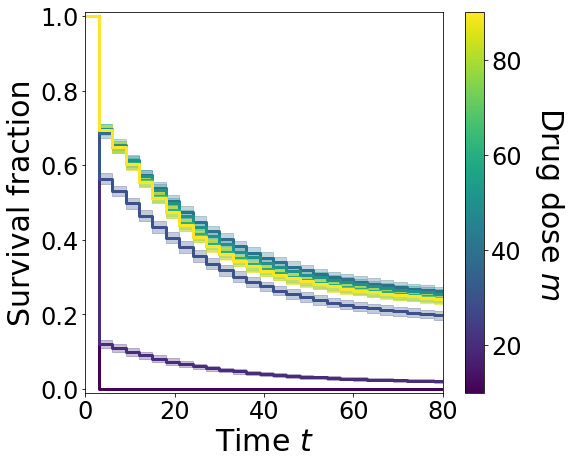

In [37]:
fig = plt.figure(figsize=(8,7))

colors = plt.cm.viridis(np.linspace(0,1,len(mvec)))

for ii in range(len(mvec)):
    plt.step(tspan,KM_mean[ii,:],'-',label="m = "+str(mvec[ii]),where='post',color=colors[ii],linewidth=3)
    plt.fill_between(tspan, KM_mean[ii,:]-KM_stdev[ii,:], KM_mean[ii,:]+KM_stdev[ii,:], alpha=0.3,step='post',color=colors[ii]) # error bars

#plt.legend()
scalarmappaple = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
scalarmappaple.set_array(mvec)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label('Drug dose $m$',rotation=270,labelpad=45)
plt.ylabel(r"Survival fraction")
plt.xlabel(r"Time $t$")
plt.ylim([-0.01,1.01])
plt.xlim([0,80])
plt.savefig('../manuscript/figures/individual/KM_mean_Case'+mycase+'.svg')
plt.savefig('../manuscript/figures/individual/KM_mean_Case'+mycase+'.png',dpi=300)

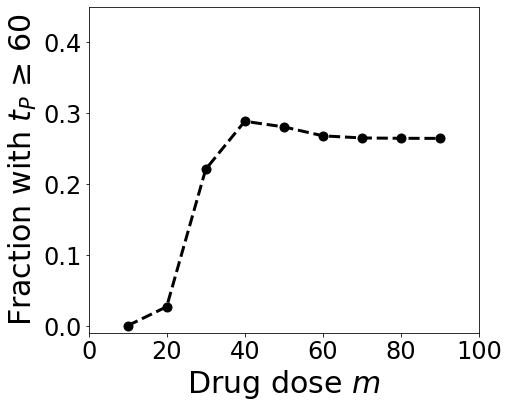

In [38]:
idx = 20
fig = plt.figure(figsize=(7,6))
plt.plot(mvec,KM_mean[:,idx],'k--o',markersize=9,linewidth=3)
plt.ylabel(r"Fraction with $t_P$ ≥ "+str(round(tspan[idx])))
plt.xlabel(r"Drug dose $m$")
#plt.title('Survival fraction at $t = $'+str(round(tspan[idx])))
plt.xlim([0,100])
plt.ylim([-0.01,0.45])

ax = plt.gca()
ax.errorbar(mvec,KM_mean[:,idx],
            yerr=KM_stdev[:,idx]/np.sqrt(n_vpc),
            fmt='none',
            capsize=4,ecolor = 'k')
plt.savefig('../manuscript/figures/individual/KM_slice_Case'+mycase+'.svg')
plt.savefig('../manuscript/figures/individual/KM_slice_Case'+mycase+'.png',dpi=300)

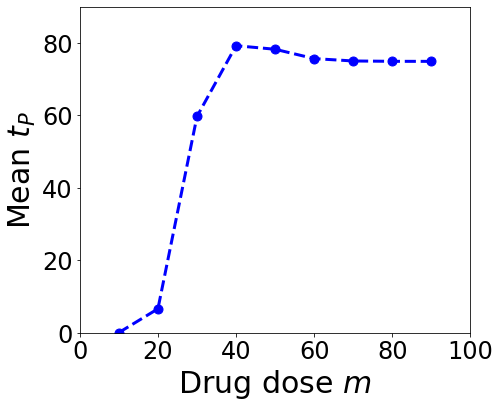

In [39]:
fig = plt.figure(figsize=(7,6))  
plt.plot(mvec,np.mean(TTParray,axis=(1,2)),'b--o',markersize=9,linewidth=3)
#plt.title('cohort size $N = $'+str(N))
plt.ylabel(r"Mean $t_P$")
plt.xlabel(r"Drug dose $m$")
#plt.title('Case A')
plt.xlim([0,100])
plt.ylim([0,90])

ax = plt.gca()
ax.errorbar(mvec, np.mean(TTParray,axis=(1,2)),
            yerr=np.std(TTParray,axis=(1,2))/np.sqrt(N*n_vpc),
            fmt='none',
            capsize=4,ecolor = 'blue')
plt.savefig('../manuscript/figures/individual/TTP_mean_Case'+mycase+'.svg')
plt.savefig('../manuscript/figures/individual/TTP_mean_Case'+mycase+'.png',dpi=300)

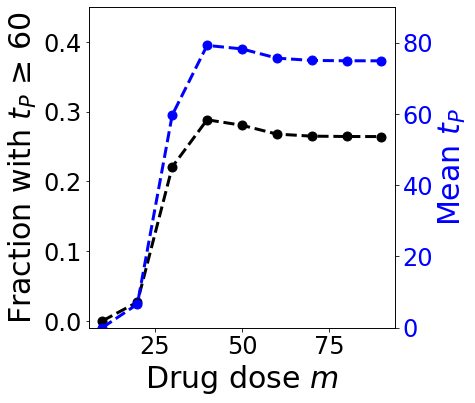

In [40]:
# plot mean TTP and survival fraction on same plot with different scales
fig, ax1 = plt.subplots(figsize=(7,6))

idx = 20
color = 'k'
ax1.set_xlabel('Drug dose $m$')
ax1.set_ylabel("Fraction with $t_P$ ≥ "+str(round(tspan[idx])), color=color)
ax1.set_ylim([-0.01,0.45])
ax1.plot(mvec,KM_mean[:,idx],color+'--o',markersize=9,linewidth=3)
ax1.errorbar(mvec,KM_mean[:,idx],
            yerr=KM_stdev[:,idx]/np.sqrt(n_vpc),
            fmt='none',
            capsize=4,ecolor = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'b'
ax2.set_ylabel('Mean $t_P$', color=color)  # we already handled the x-label with ax1
ax2.set_ylim([-0.01,90])
ax2.plot(mvec, TTP_mean, color+'--o',markersize=9,linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(mvec, TTP_mean,
            yerr=TTP_stdev/np.sqrt(N*n_vpc),
            fmt='none',
            capsize=4,ecolor = 'blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('../manuscript/figures/individual/plotboth_Case'+mycase+'.svg')
plt.savefig('../manuscript/figures/individual/plotboth_Case'+mycase+'.png',dpi=300)